In [1]:
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from esda.moran import Moran
import seaborn
from sklearn.cluster import KMeans
from sklearn.preprocessing import robust_scale

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
# Load regression gds 
selected = gpd.read_file('../YouthInTheCity/data/cluster_gdf.shp')

In [3]:
selected.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'night_life', 'water', 'E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
       'E_E18U25', 'E_E25U55', 'E_E55U65', 'E_E65U80', 'E_E80U110', 'mig_rate',
       'HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
       'HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'ave_rent', 'dyn_wel_po', 'welf_po',
       'social_hou', 'public_hou', 'dyn_ew', 'five_y_pls', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'BZR_NAME', 'unemployme', 'welfare',
       'child_pov', 'dyn_unempl', 'dyn_welfar', 'dyn_child', 'noise', 'air',
       'green', 'bio', 'total_buil', 'B_1940', 'B_1941_199', 'B_1991_201',
       'B_age', 'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'sp_nee_sch', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [4]:
selected.drop(columns=['E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
            'E_E18U25', 'E_E25U55', 'E_E55U65', 'E_E65U80', 'E_E80U110', 'mig_rate',
            'HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
            'HK_Arab', 'HK_Sonst', 'HK_NZOrd','BZR_NAME', 'total_buil','B_age', 'ch_rate',
            'sp_nee_sch','noise','green','night_life','culture','dyn_wel_po', 'welf_po',
            'dyn_ew','five_y_pls', 'unemployme', 'welfare',
           'dyn_unempl', 'dyn_welfar', 'dyn_child'], 
             inplace=True)

In [ ]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)

In [5]:
y_b = selected['child_pov']
X_b = selected.drop(columns=['child_pov','PLR_ID','geometry'])

In [6]:
### Perform permutation

#fit model
model = LinearRegression().fit(X_b,y_b)
#Perform permutation
permutation_score = permutation_importance(model, X_b,y_b, n_repeats=100)
#Unstack results, put in df
importance_df = pd.DataFrame(np.vstack((X_b.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']
#Order by importance
importance_df.sort_values(by='feature importance', ascending = False, inplace=True)
importance_df
#remove feature that have lower feature importance, run the validation score to test the reduced feature

,feature,feature importance
14,dyn_r_to_p,0.206787
2,community,0.189916
15,sales,0.128108
20,B_1941_199,0.104395
18,bio,0.10407
10,ave_rent,0.089533
16,dyn_sales,0.084224
11,social_hou,0.075884
4,public_ser,0.054738
21,B_1991_201,0.054034


In [7]:
selected.columns 

Index(['PLR_ID', 'public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'child_pov', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [8]:
col = ['public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'child_pov', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations']

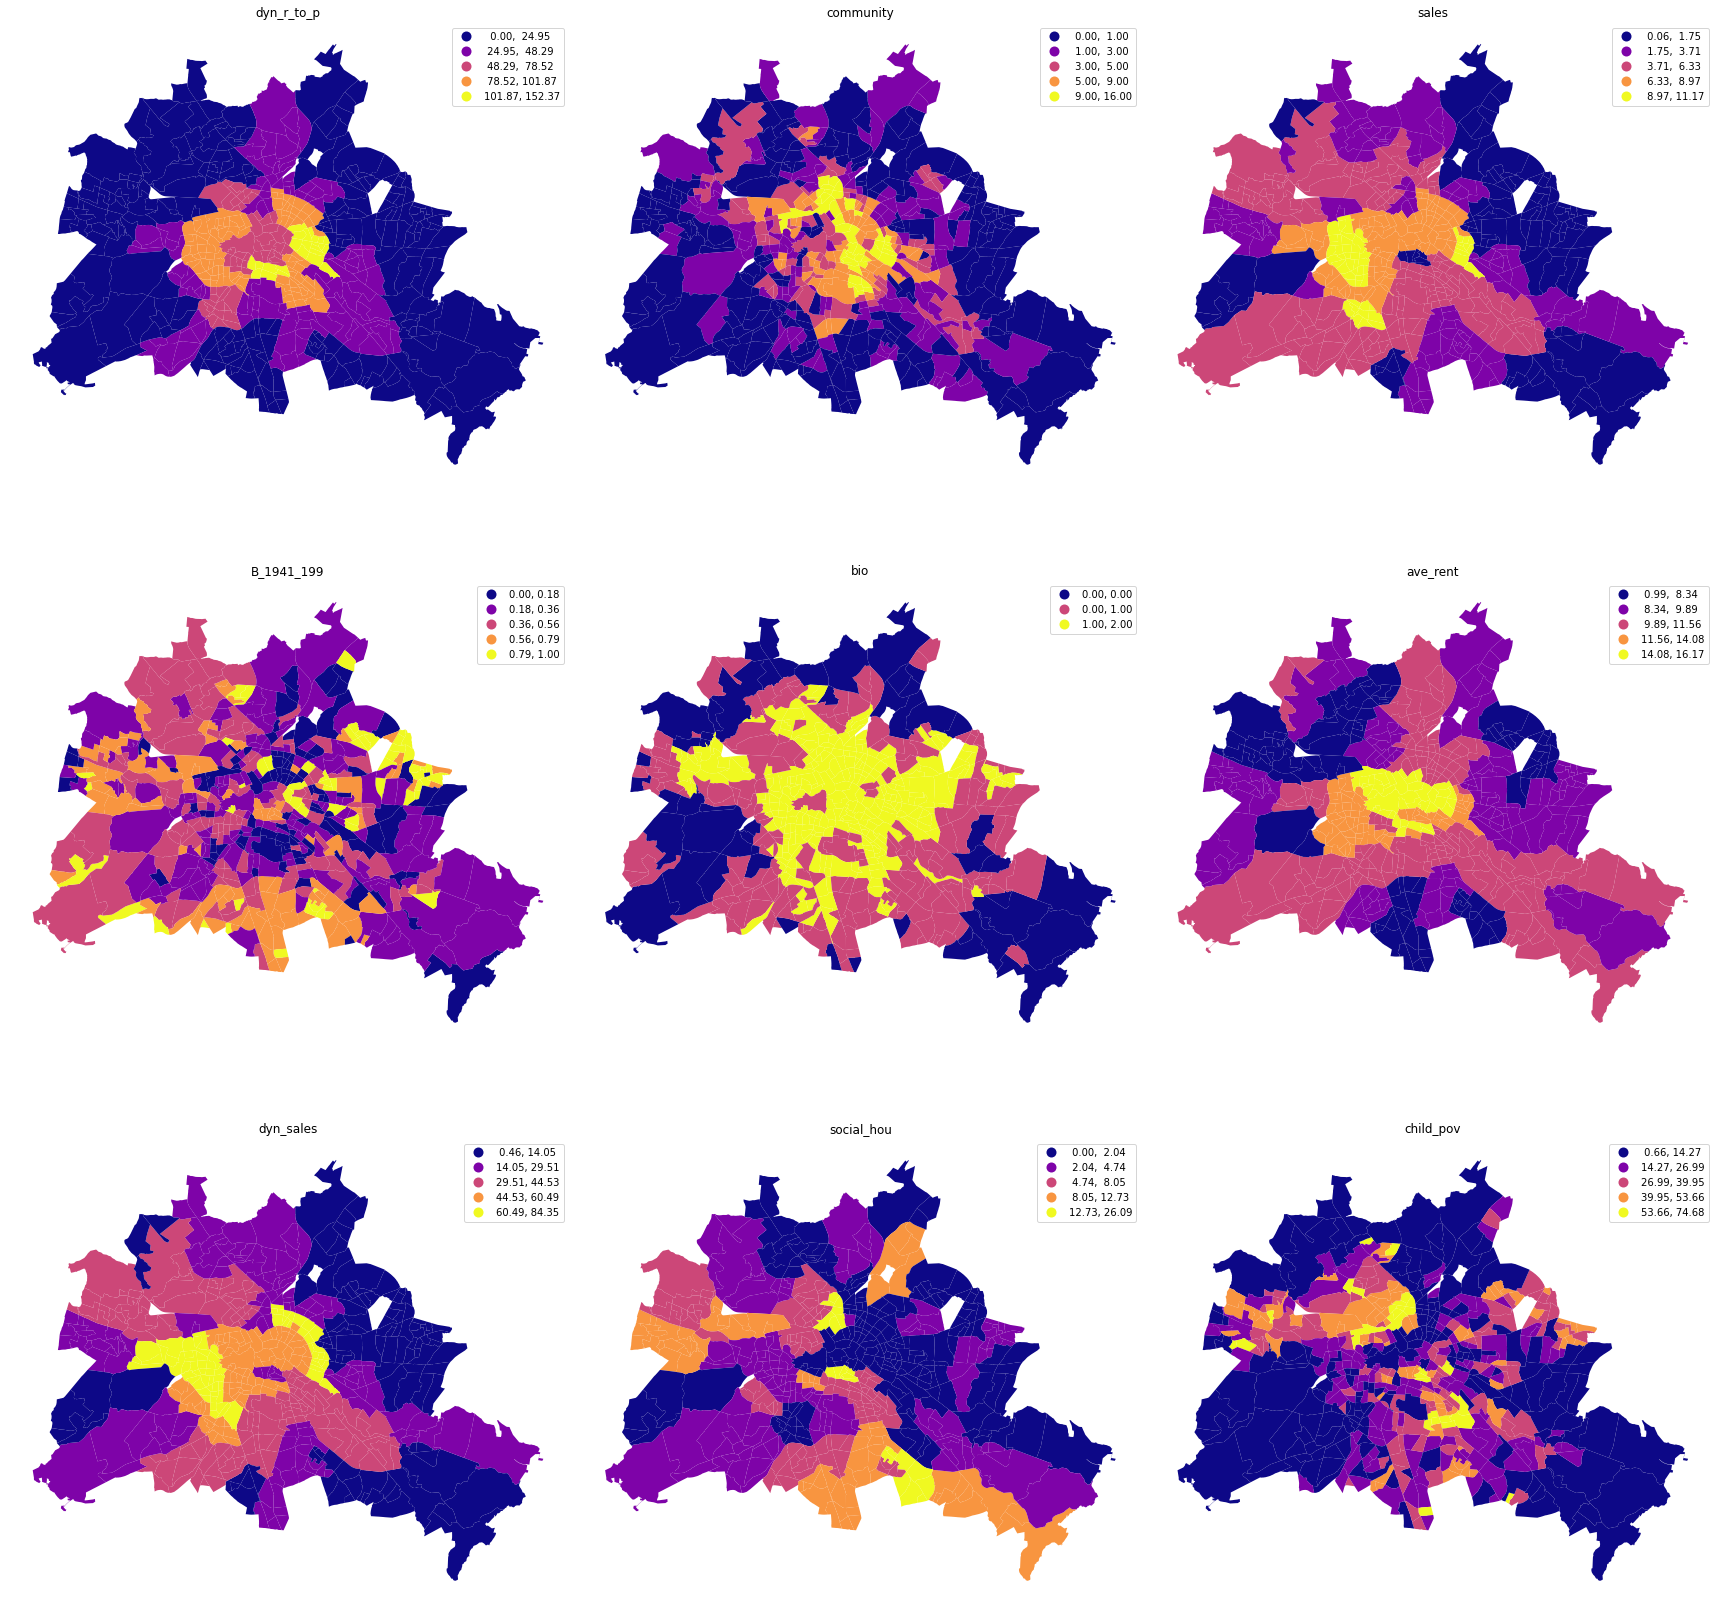

In [10]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(iterable=clusters):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    selected.plot(
        column=col,
        ax=ax,
        scheme='natural_breaks',
        linewidth=0,
        cmap="plasma",
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()

In [12]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(selected[variable], inv_dist) for variable in clusters
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clusters, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
dyn_r_to_p,0.653350,0.001
community,0.481454,0.001
sales,0.643220,0.001
B_1941_199,0.226659,0.001
bio,0.414672,0.001
ave_rent,0.600497,0.001
dyn_sales,0.616396,0.001
social_hou,0.328510,0.001
child_pov,0.287077,0.001


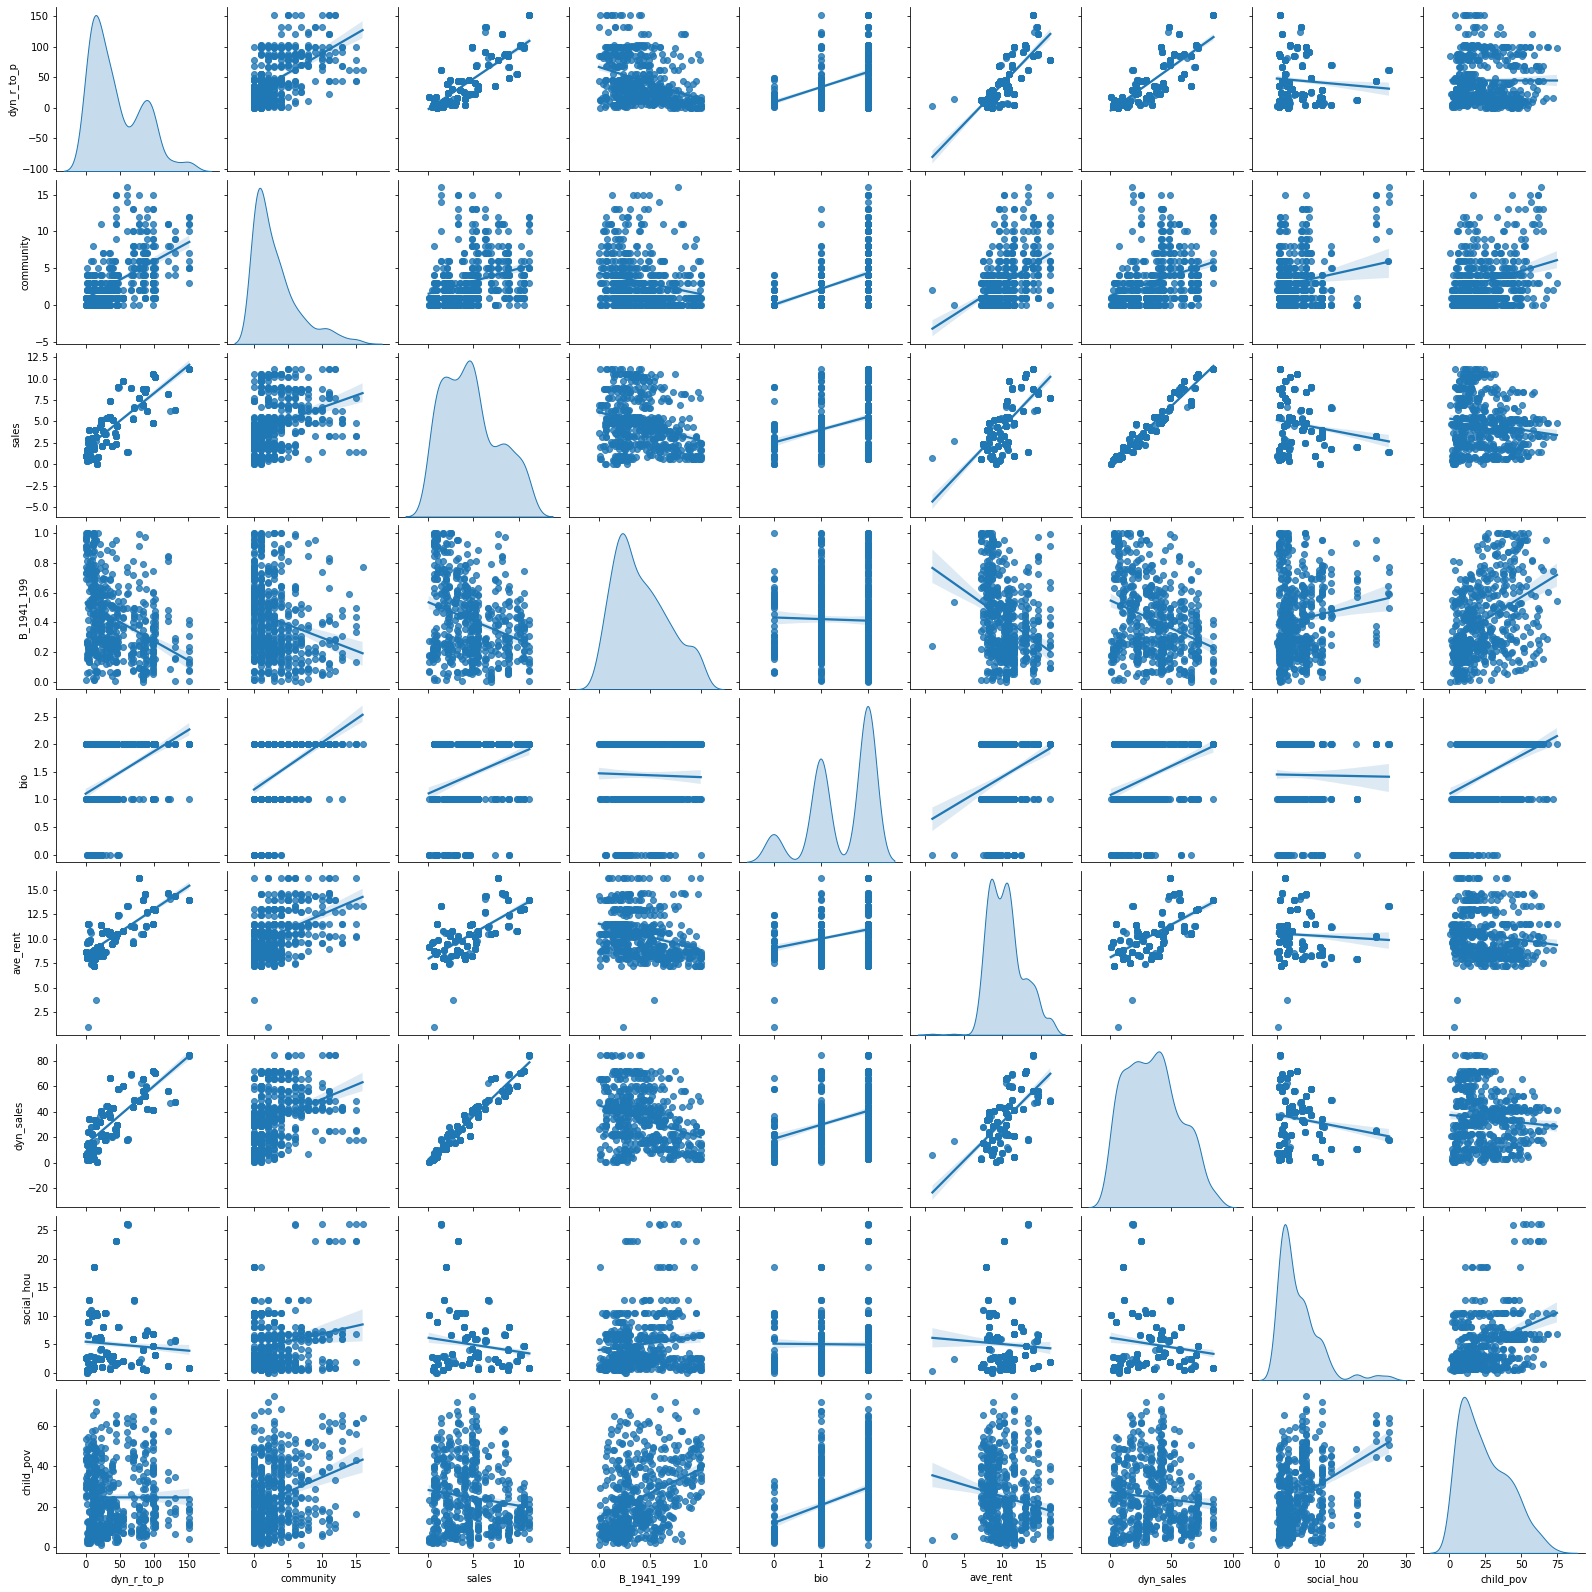

In [13]:
_ = seaborn.pairplot(
    selected[clusters], kind="reg", diag_kind="kde"
)

In [51]:
kmeans = KMeans(n_clusters=5)

## Clusters with most important features in child poverty regression

In [52]:
clusters = list(np.append(importance_df.head(8).feature.values, ('child_pov')))

In [53]:
selected[clusters]

,dyn_r_to_p,community,sales,B_1941_199,bio,ave_rent,dyn_sales,social_hou,child_pov
0,43.485219,2.0,3.712392,0.060269,1.0,9.750770,26.607421,1.302637,2.58
1,88.376721,8.0,8.809615,0.070704,2.0,11.261721,59.896169,0.390507,8.13
2,4.410000,0.0,1.730000,0.757727,1.0,8.100000,11.040000,12.720000,41.68
3,152.370000,6.0,11.170000,0.309616,2.0,13.970000,84.350000,0.740000,21.15
4,10.720000,6.0,2.330000,0.977334,2.0,7.550000,15.780000,1.560000,51.53
...,...,...,...,...,...,...,...,...,...
531,10.720000,1.0,2.330000,0.549494,1.0,7.550000,15.780000,1.560000,20.69
532,30.077286,0.0,2.590062,0.290537,0.0,10.759385,22.109248,3.209599,4.24
533,4.192183,1.0,0.540178,0.213530,1.0,9.710094,2.412211,0.550044,2.89
534,98.751285,13.0,4.850590,0.171995,1.0,11.521094,41.442492,6.729473,40.42


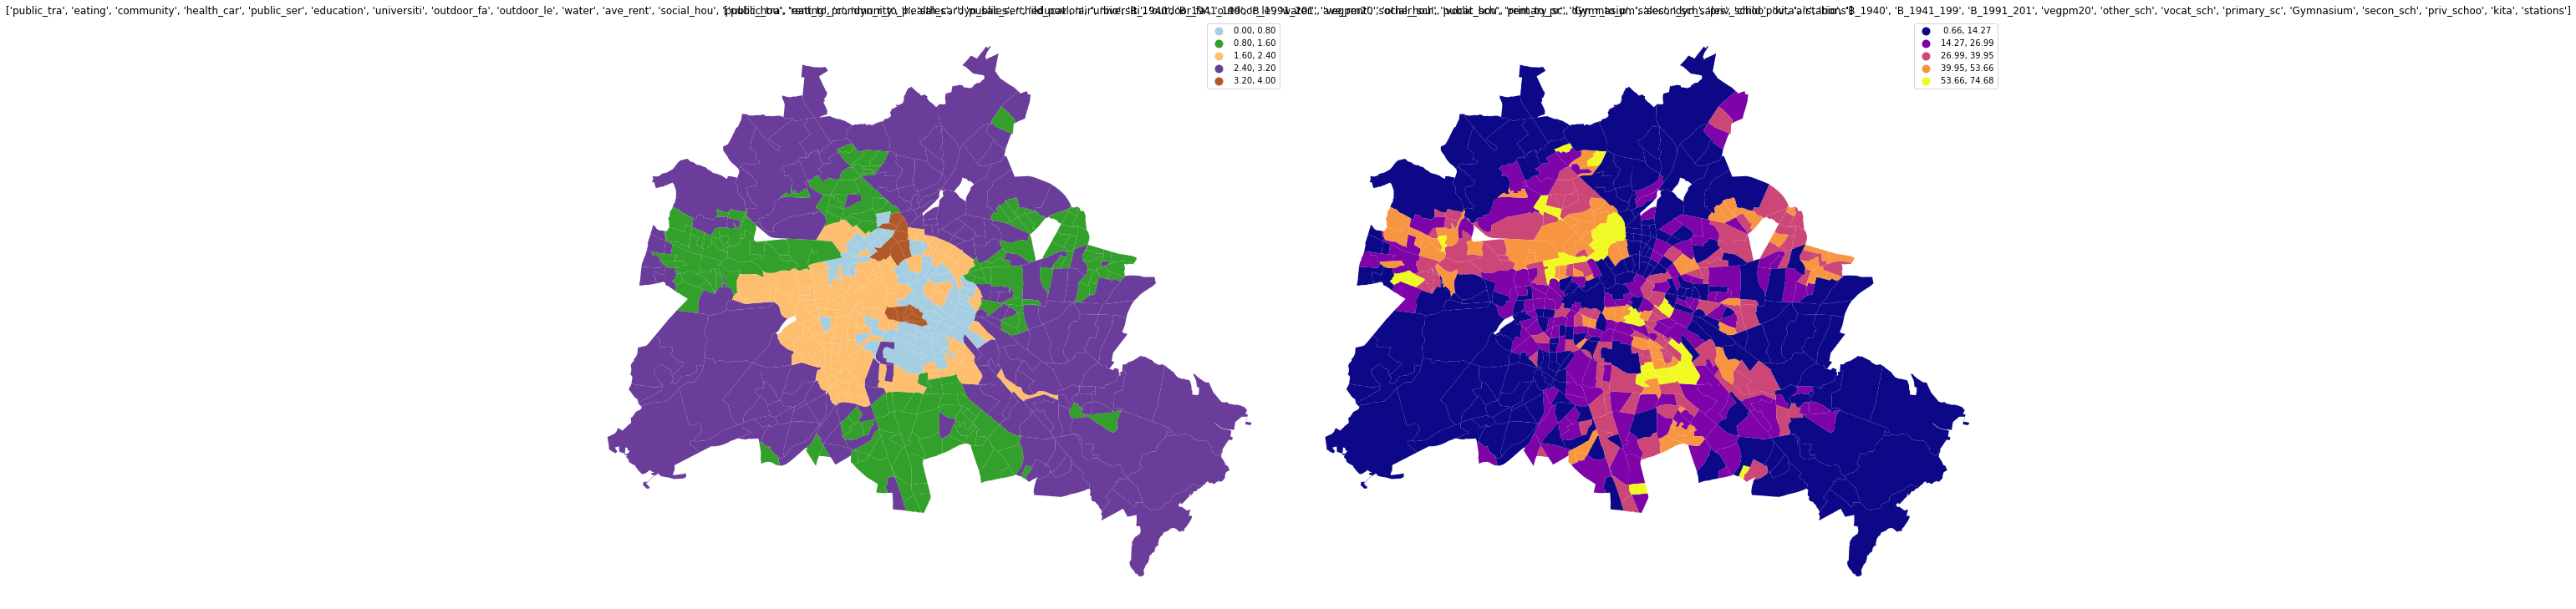

In [54]:
db_scaled = robust_scale(selected[clusters])
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

selected["k5cls"] = k5cls.labels_

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()

ax = axs[0]
# Plot the map
selected.plot(
    column='k5cls',
    ax=ax,
    scheme="EqualInterval",
    linewidth=0,
    cmap="Paired",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
ax.set_title(col)    
    
ax = axs[1]
# Plot the map
selected.plot(
    column='child_pov',
    ax=ax,
    scheme='natural_breaks',
    linewidth=0,
    cmap="plasma",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()


In [55]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
dyn_r_to_p,94.487,14.724,82.622,23.142,51.982
community,9.369,1.622,3.191,1.421,11.769
sales,7.009,2.660,8.410,3.022,2.419
B_1941_199,0.243,0.669,0.335,0.309,0.553
bio,1.908,1.532,1.740,0.924,2.000
ave_rent,12.546,8.387,12.507,9.796,11.679
dyn_sales,51.700,20.715,60.198,22.393,22.065
social_hou,4.575,6.299,3.883,3.258,24.440
child_pov,28.990,35.812,21.859,12.191,56.489


In [56]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0     65
1    156
2    131
3    171
4     13
dtype: int64

In [57]:
np.corrcoef(selected["k5cls"], selected["child_pov"])

array([[ 1.        , -0.37555074],
       [-0.37555074,  1.        ]])

## Clusters with infrastructre features + child poverty

In [58]:
col = ['public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'child_pov', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations']

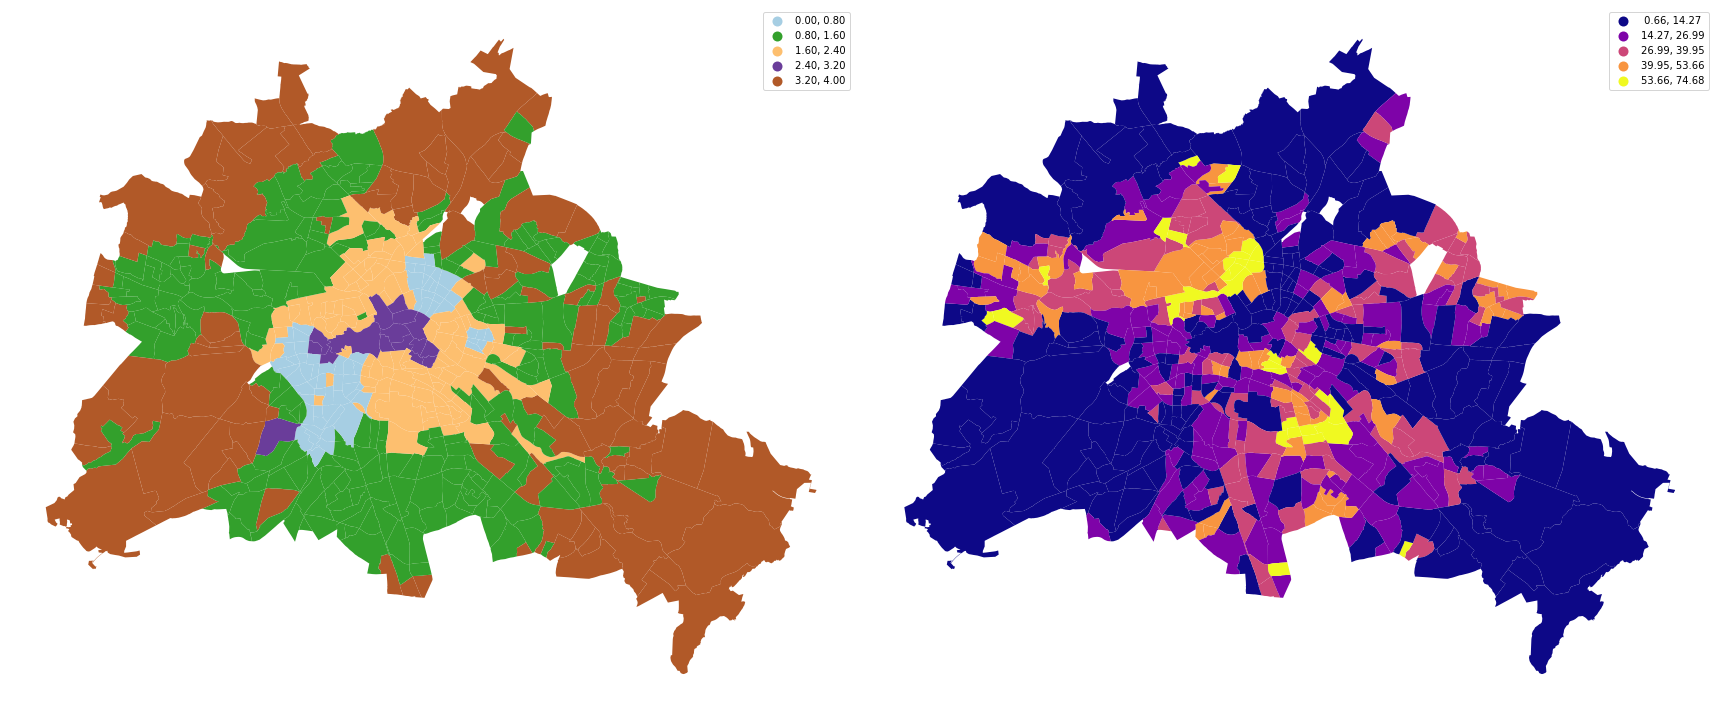

In [70]:
db_scaled = robust_scale(selected[col])

kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

selected["k5cls"] = k5cls.labels_

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()

ax = axs[0]
# Plot the map
selected.plot(
    column='k5cls',
    ax=ax,
    scheme="EqualInterval",
    linewidth=0,
    cmap="Paired",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)    
    
ax = axs[1]
# Plot the map
selected.plot(
    column='child_pov',
    ax=ax,
    scheme='natural_breaks',
    linewidth=0,
    cmap="plasma",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()


In [62]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
dyn_r_to_p,89.557,22.994,81.693,78.408,18.550
community,4.485,1.677,6.681,7.438,1.009
sales,9.053,3.476,6.155,7.562,2.636
B_1941_199,0.260,0.572,0.326,0.343,0.295
bio,1.912,1.418,1.885,1.812,0.692
ave_rent,12.159,9.064,12.206,14.897,9.739
dyn_sales,65.499,26.461,45.414,49.195,19.462
social_hou,2.932,5.284,6.707,4.294,3.848
child_pov,14.991,29.954,33.084,19.721,10.569


In [63]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0     68
1    232
2    113
3     16
4    107
dtype: int64

In [64]:
np.corrcoef(selected["k5cls"], selected["child_pov"])

array([[ 1.        , -0.25966551],
       [-0.25966551,  1.        ]])

## Clusters with infrastructre features + child poverty

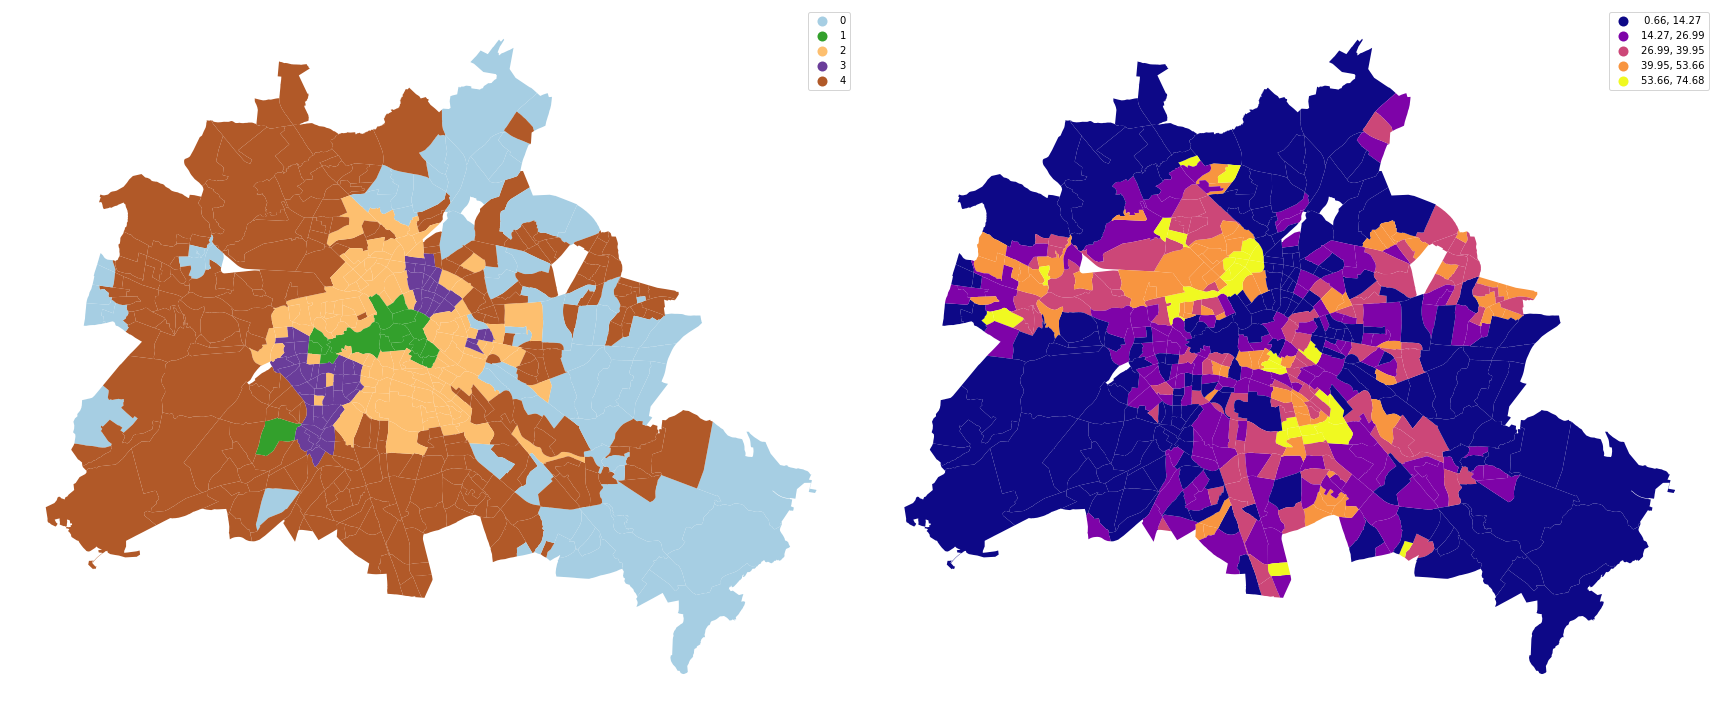

In [67]:
infra = ['public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations']

db_scaled = robust_scale(selected[infra])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

selected["k5cls"] = k5cls.labels_

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
selected["k5cls"] = k5cls.labels_

ax = axs[0]
# Plot the map
selected.plot(
    column='k5cls',
    ax=ax,
    categorical=True,
    linewidth=0,
    cmap="Paired",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)    
    
ax = axs[1]
# Plot the map
selected.plot(
    column='child_pov',
    ax=ax,
    scheme='natural_breaks',
    linewidth=0,
    cmap="plasma",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()


In [71]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls").mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
PLR_ID,4752302.353,8059710.112,4111186.062,2181639.812,7695155.776
public_tra,106.044,100.797,122.726,220.250,95.009
eating,166.147,19.983,109.867,263.500,13.224
community,4.485,1.677,6.681,7.438,1.009
health_car,77.941,16.211,42.876,41.625,9.467
public_ser,30.191,15.819,25.832,35.562,14.935
education,4.147,0.216,1.301,1.312,0.150
universiti,1.412,0.349,0.832,5.375,0.234
outdoor_fa,157.221,118.366,249.097,406.750,99.944
outdoor_le,5.662,8.375,9.407,8.312,5.664


In [68]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0     73
1     16
2    120
3     60
4    267
dtype: int64

In [69]:
np.corrcoef(selected["k5cls"], selected["child_pov"])

array([[1.        , 0.22372119],
       [0.22372119, 1.        ]])

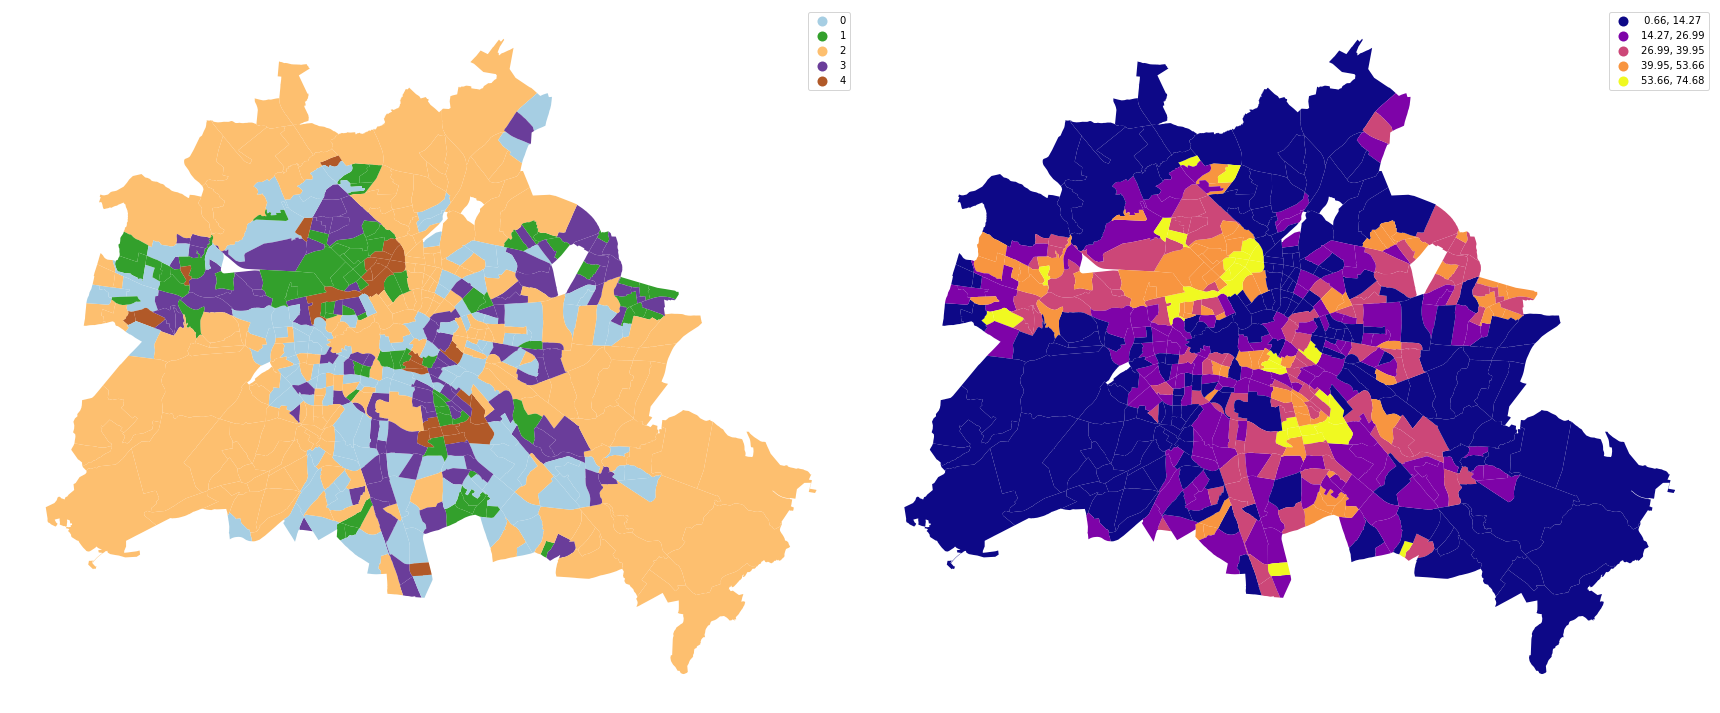

In [73]:


db_scaled = robust_scale(selected['child_pov'])

# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled.reshape(-1, 1))

selected["k5cls"] = k5cls.labels_

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
selected["k5cls"] = k5cls.labels_

ax = axs[0]
# Plot the map
selected.plot(
    column='k5cls',
    ax=ax,
    categorical=True,
    linewidth=0,
    cmap="Paired",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)    
    
ax = axs[1]
# Plot the map
selected.plot(
    column='child_pov',
    ax=ax,
    scheme='natural_breaks',
    linewidth=0,
    cmap="plasma",
    legend=True
)
# Remove axis clutter
ax.set_axis_off()
# Set the axis title to the name of variable being plotted
#ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()


In [74]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls").mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
PLR_ID,6359949.681,6870302.395,6199225.577,7751050.515,4789895.786
public_tra,117.133,99.053,108.789,103.262,109.714
eating,74.067,47.829,68.433,49.262,71.286
community,2.793,3.776,2.433,3.204,7.500
health_car,29.622,26.605,31.799,24.544,30.964
public_ser,22.489,17.079,20.706,18.398,20.107
education,1.030,0.632,1.263,0.573,0.893
universiti,0.852,0.592,0.840,0.485,0.321
outdoor_fa,152.785,152.921,149.433,166.864,181.321
outdoor_le,8.356,6.987,6.680,9.262,7.893
